In [52]:
import json
import os
import numpy as np
from pprint import pprint
from copy import deepcopy
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, auc

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
from torchvision.ops import box_iou, nms
from tqdm import tqdm
from ensemble_boxes import nms as wbf_nms
from ensemble_boxes import soft_nms as wbf_snms
from ensemble_boxes import non_maximum_weighted, weighted_boxes_fusion

In [53]:
def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [54]:
SEG_anno_path = '../data/N4_SEG_img/'
SEG_anno_list = sorted(os.listdir(SEG_anno_path))

seg_count_dict = {}

for seg_anno in tqdm(SEG_anno_list):
    seg_anno_name = '_'.join(seg_anno.split('_')[:-1])
    if seg_anno_name not in seg_count_dict:
        seg_count_dict[seg_anno_name] = {'GT':[],
                                         'Hit':[]}
    seg_anno_array = np.load(SEG_anno_path + seg_anno)['BBOX']
    seg_anno_label_list = np.unique(seg_anno_array).tolist()
    for anno_label in seg_anno_label_list:
        if anno_label == 0:
            continue
        elif anno_label in seg_count_dict[seg_anno_name]['GT']:
            continue
        else:
            seg_count_dict[seg_anno_name]['GT'].append(anno_label)

100%|██████████| 612/612 [00:01<00:00, 322.61it/s]


In [58]:
model_path = '../test_output/N4_All/'
pprint([each for each in sorted(os.listdir(model_path))])

['MCS_NL23_bs16_iou03_size448',
 'MCS_NL3_bs16_iou03_size448',
 'MCSdv0123_bs16_iou03_size448',
 'MCSdv123_bs16_iou03_size448',
 'MCSdv23_bs16_iou03_size448',
 'MCSdv23_bs16_iou03_size896',
 'MCSdv3_bs16_iou03_size448',
 'MC_CO_dv0123_bs16_iou03_size448',
 'MC_CO_dv123_bs16_iou03_size448',
 'MC_CO_dv23_bs16_iou03_size448',
 'MC_CO_dv23_bs16_iou03_size896',
 'MC_CO_dv3_bs16_iou03_size448',
 'MC_CO_dv3_bs16_iou03_size896',
 'MC_SE_dv3_bs16_iou03_size896',
 'MCpre_bs16_iou03_size672',
 'MCpre_bs16_iou03_size896',
 'mask_rcnn_1_SEG',
 'mask_rcnn_FLAIR_SEG',
 'mask_rcnn_T1T2',
 'mask_rcnn_T1_SEG',
 'mask_rcnn_T2FLAIR',
 'mask_rcnn_T2_SEG',
 'mrDS_bs16_iou03_size892',
 'mrSAdv23_bs16_iou03_size448',
 'mrSAdv23_bs16_iou03_size896',
 'mrSAdv3_bs16_iou03_size448',
 'mrSAdv3_bs16_iou03_size896',
 'mr_bs16_iou03_size448_base1',
 'mr_bs16_iou03_size448_base2',
 'mr_bs16_iou03_size896',
 'mr_bs16_iou03_size896_base2',
 'mrcls',
 'mrcls3w01_bs16_iou03_size448',
 'mrcls_BCE_p_w01_bs16_iou03_size448',

In [152]:
key = 'MP_b012_CO_dv0123_bs16_iou03_size896'

result_path = '../test_output/N4_All/' + key + '/'
print(result_path)
result_list = sorted([each for each in os.listdir(result_path)])

NMS_IOU = 0.01

result_list = sorted([each for each in os.listdir(result_path) if each[0] == 'K'])
K_pid_score = {}

for k_idx in range(0,5):
    K_pid_score[str(k_idx)] = {}
    
    tmp_result_npz = [each for each in result_list if each.startswith('K%s'%k_idx)][0]
    print(tmp_result_npz)
    tmp_result_path = result_path + tmp_result_npz
    tmp_result_file = np.load(tmp_result_path, allow_pickle=True)
    case_list = tmp_result_file['case']

    all_detections = tmp_result_file['det']
    all_annotations = tmp_result_file['anno']
    
    false_positives = np.zeros((0,))
    true_positives = np.zeros((0,))
    scores = np.zeros((0,))
    num_annotations = 0.0
    
    for i in range(len(case_list)):
        case = case_list[i]
        pid = '_'.join(case.split('_')[:-1])
        
        if pid not in K_pid_score[str(k_idx)]:
            K_pid_score[str(k_idx)][pid] = [0]
        
        detections = all_detections[i]
        annotations = all_annotations[i]
        num_annotations += annotations.shape[0]
        detected_annotations = []
        
        bb_scores = torch.tensor(detections[:,4])
        anchorBoxes = torch.tensor(detections[:,:4])
        anchors_nms_idx = nms(anchorBoxes, bb_scores, 0.1)
        anchors_nms_idx = anchors_nms_idx.numpy()
        detections = detections[anchors_nms_idx]
        
        for d in detections:
            det_score = d[4]
            K_pid_score[str(k_idx)][pid] += [det_score]
    
    for pid, score_list in K_pid_score[str(k_idx)].items():
        K_pid_score[str(k_idx)][pid] = np.mean(sorted(score_list)[-3:])

../test_output/N4_All/MP_b012_CO_dv0123_bs16_iou03_size896/
K0_output.npz
K1_output.npz
K2_output.npz
K3_output.npz
K4_output.npz


In [153]:
S_IOU = 0.05
H_IOU = 0.3
NMS_IOU = 0.1
# nms, snms, nmw, wbf
if True:
    result_list = sorted([each for each in os.listdir(result_path) if each[0] == 'K'])

    ensemble_case_list = None
    ensemble_detections = []
    ensemble_annotations = None

    for k_idx in range(0,5):
        tmp_result_npz = [each for each in result_list if each.startswith('K%s'%k_idx)][0]
        print(tmp_result_npz)
        tmp_result_path = result_path + tmp_result_npz
        tmp_result_file = np.load(tmp_result_path, allow_pickle=True)

        case_list = tmp_result_file['case']
        all_detections = tmp_result_file['det']
        all_annotations = tmp_result_file['anno']

        if k_idx == 0:
            ensemble_case_list = case_list
            ensemble_annotations = all_annotations

        for i in range(len(case_list)):
            case_name = case_list[i]
            seg_anno_name = '_'.join(case_name.split('_')[:-1])

            detections = all_detections[i]
            detections[:,4] = detections[:,4] * K_pid_score[str(k_idx)][seg_anno_name]

            if k_idx == 0:
                ensemble_detections.append([detections])
            else:
                ensemble_detections[i] += [detections]
    
    false_positives = np.zeros((0,))
    true_positives = np.zeros((0,))
    scores = np.zeros((0,))
    num_annotations = 0.0

    pos_pid_list = []
    neg_pid_list = []
    pos_score_list = []
    neg_score_list = []

    for i in range(len(ensemble_case_list)):
        case_name = ensemble_case_list[i]
        seg_anno_name = '_'.join(case_name.split('_')[:-1])
        
        annotations = ensemble_annotations[i]
        num_annotations += annotations.shape[0]
        detected_annotations = []
        
        detections = ensemble_detections[i]
        detections_concat = np.concatenate(detections, axis=0)
        
        if len(detections_concat) == 0:
            if annotations.shape[0] == 0:
                if seg_anno_name[0] == 'I':
                    neg_pid_list.append(seg_anno_name)
                    neg_score_list.append(0)
            continue
        
        boxes_list = [each[:,:4] / 448 for each in detections]
        scores_list = [each[:,-1] for each in detections]
        labels_list = [np.ones_like(each[:,-1]) for each in detections]
        weights = [1,1,1,1,1]
        iou_thr = NMS_IOU
        skip_box_thr = 0.0001
        
        boxes, nms_scores, labels = non_maximum_weighted(boxes_list, 
                                            scores_list, 
                                            labels_list, 
                                            weights=weights, 
                                            iou_thr=iou_thr,
                                            skip_box_thr=skip_box_thr)
        
        boxes = boxes * 448
        nms_scores = nms_scores[:,np.newaxis]
        detections = np.concatenate([boxes, nms_scores], axis=1)
        
        if len(detections) == 0:
            if annotations.shape[0] == 0:
                if seg_anno_name[0] == 'I':
                    neg_pid_list.append(seg_anno_name)
                    neg_score_list.append(0)
            continue

        detections = np.array(sorted(detections.tolist(), key=lambda x:x[-1], reverse=True))

        for d in detections:
            if d[4] < S_IOU:
                continue

            tmp_score = d[4]# * K_pid_score[str(k_idx)][seg_anno_name]
            scores = np.append(scores, tmp_score)

            if annotations.shape[0] == 0:
                false_positives = np.append(false_positives, 1)
                true_positives = np.append(true_positives, 0)

                if seg_anno_name[0] == 'I':
                    neg_pid_list.append(seg_anno_name)
                    neg_score_list.append(tmp_score)
                continue

            d_tensor = torch.tensor(d[:4][np.newaxis])
            a_tensor = torch.tensor(annotations)
            overlaps = box_iou(d_tensor, a_tensor).numpy()
            assigned_annotation = np.argmax(overlaps, axis=1)
            max_overlap = overlaps[0, assigned_annotation]

            if max_overlap >= H_IOU:
                if assigned_annotation not in detected_annotations:
                    false_positives = np.append(false_positives, 0)
                    true_positives = np.append(true_positives, 1)
                    detected_annotations.append(assigned_annotation)

                    if seg_anno_name[0] != 'I':
                        pos_pid_list.append(seg_anno_name)
                        pos_score_list.append(tmp_score)
                else:
                    false_positives = np.append(false_positives, 1)
                    true_positives = np.append(true_positives, 0)
            else:
                false_positives = np.append(false_positives, 1)
                true_positives = np.append(true_positives, 0)
                if seg_anno_name[0] == 'I':
                    neg_pid_list.append(seg_anno_name)
                    neg_score_list.append(tmp_score)

    if len(false_positives) == 0 and len(true_positives) == 0:
        print('No detection')
    else:
        # sort by score
        indices = np.argsort(-scores)
        scores = scores[indices]
        false_positives = false_positives[indices]
        true_positives = true_positives[indices]

        anno = num_annotations
        case_num = len(case_list)

        # compute false positives and true positives
        false_positives = np.cumsum(false_positives)
        true_positives = np.cumsum(true_positives)

        # compute recall and precision
        recall = true_positives / num_annotations
        precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)

        # compute average precision
        average_precision = compute_ap(recall, precision)

        recall_copy = deepcopy(recall)
        recall_copy[recall_copy < 0.8] = 0
        recall_th_idx = np.argmin(np.abs(recall_copy - 0.8))

        recall_max = recall[recall_th_idx]
        precision_max = precision[recall_th_idx]
        while precision[recall_th_idx] >= precision_max:
            recall_th_idx += 1

        recall = recall[recall_th_idx]
        precision = precision[recall_th_idx]

        print('mAP: {:.4f}'.format(average_precision))
        print("Precision: {:.4f}".format(precision))
        print("Recall: {:.4f}".format(recall))
        print("F1-Score: {:.4f}".format(2*recall*precision/(recall+precision)))

        fp_list = false_positives
        tp_list = true_positives

        fps_list = []

        for th in [0.05, 0.125, 0.25, 0.5, 1]:
            fp_th_idx = np.argmin(np.abs(fp_list / case_num - th))
            tp_th = tp_list[fp_th_idx]
            print('%s - %1.3f'%(scores[fp_th_idx], th), (tp_th / anno).round(4))
            fps_list.append(tp_th / anno)
        print('Mean:', np.mean(fps_list).round(4))

    unique_score_list = sorted(list(set(pos_score_list + neg_score_list)))
    unique_score_list.insert(0, -1)
    unique_score_list.append(1.1)

    unique_pid_list = np.unique(np.array(neg_pid_list).tolist())
    Neg_pid_num = len(np.unique(np.array(neg_pid_list).tolist()))

    sens_case_list = []
    spec_pid_list = []

    for th_score in unique_score_list:
        TP_case_num = np.sum(np.array(pos_score_list) > th_score)
        sens_case = TP_case_num / num_annotations
        sens_case_list.append(sens_case)

        FP_pid_num = len(np.unique(np.array(neg_pid_list)[np.array(neg_score_list) > th_score]).tolist())
        spec_pid_list.append(FP_pid_num/Neg_pid_num)

    print('AFROC:', auc(spec_pid_list, sens_case_list).round(4))
    print('========================================')


K0_output.npz
K1_output.npz
K2_output.npz
K3_output.npz
K4_output.npz
mAP: 0.8402
Precision: 0.7178
Recall: 0.8003
F1-Score: 0.7568
0.8747839331626892 - 0.050 0.7201
0.7711428999900818 - 0.125 0.8245
0.6408675312995911 - 0.250 0.8865
0.42179757356643677 - 0.500 0.9365
0.20117351412773132 - 1.000 0.9531
Mean: 0.8641
AFROC: 0.8234


In [154]:
H_IOU = 0.3
NMS_IOU = 0.1
th = 0.8

if True:
    result_list = sorted([each for each in os.listdir(result_path) if each[0] == 'K'])

    ensemble_case_list = None
    ensemble_detections = []
    ensemble_annotations = None

    for k_idx in range(0,5):
        tmp_result_npz = [each for each in result_list if each.startswith('K%s'%k_idx)][0]
        print(tmp_result_npz)
        tmp_result_path = result_path + tmp_result_npz
        tmp_result_file = np.load(tmp_result_path, allow_pickle=True)

        case_list = tmp_result_file['case']
        all_detections = tmp_result_file['det']
        all_annotations = tmp_result_file['anno']

        if k_idx == 0:
            ensemble_case_list = case_list
            ensemble_annotations = all_annotations

        for i in range(len(case_list)):
            case_name = case_list[i]
            seg_anno_name = '_'.join(case_name.split('_')[:-1])

            detections = all_detections[i]
            detections[:,4] = detections[:,4] * K_pid_score[str(k_idx)][seg_anno_name]

            if k_idx == 0:
                ensemble_detections.append([detections])
            else:
                ensemble_detections[i] += [detections]

    false_positives = np.zeros((0,))
    true_positives = np.zeros((0,))
    scores = np.zeros((0,))
    num_annotations = 0.0

    pid_dict = {}

    for i in range(len(ensemble_case_list)):
        case = ensemble_case_list[i]
        pid = '_'.join(case.split('_')[:-1])

        if pid not in pid_dict:
            pid_dict[pid] = 0
            
        annotations = ensemble_annotations[i]
        num_annotations += annotations.shape[0]
        detected_annotations = []

        detections = ensemble_detections[i]
        detections_concat = np.concatenate(detections, axis=0)
        
        if len(detections_concat) == 0:
            continue
        
        boxes_list = [each[:,:4] / 448 for each in detections]
        scores_list = [each[:,-1] for each in detections]
        labels_list = [np.ones_like(each[:,-1]) for each in detections]
        weights = [1,1,1,1,1]
        iou_thr = 0.1
        skip_box_thr = 0.0001
        
        boxes, nms_scores, labels = non_maximum_weighted(boxes_list, 
                                            scores_list, 
                                            labels_list, 
                                            weights=weights, 
                                            iou_thr=iou_thr,
                                            skip_box_thr=skip_box_thr)
        
        boxes = boxes * 448
        nms_scores = nms_scores[:,np.newaxis]
        detections = np.concatenate([boxes, nms_scores], axis=1)

        for d in detections:
            det_score = d[4]
            pid_dict[pid] = max(pid_dict[pid], det_score)

    score_list = []
    label_list = []
    for pid in pid_dict:
        if pid[:2] == 'I_':
            label_list.append(0)
        else:
            label_list.append(1)
        score_list.append(pid_dict[pid])

    score_list = np.array(score_list)
    label_list = np.array(label_list)

    print('AUC:',round(roc_auc_score(label_list, score_list),4))
    print('ACC:',round(accuracy_score(label_list, score_list>th),4))
    print('Sens:',round(recall_score(label_list, score_list>th),4))
    print('Spec:',round(recall_score(1-label_list, score_list<=th),4))
    print('============================================')

K0_output.npz
K1_output.npz
K2_output.npz
K3_output.npz
K4_output.npz
AUC: 0.942
ACC: 0.86
Sens: 0.94
Spec: 0.78


146 144 0.9863
AFROC: 0.8547
 1  8  8 1.0
 3 17 17 1.0
 4 19 19 1.0
 5 28 28 1.0
 6 29 30 0.9667
 7  4  5 0.8
 8  6  6 1.0
 9 33 33 1.0


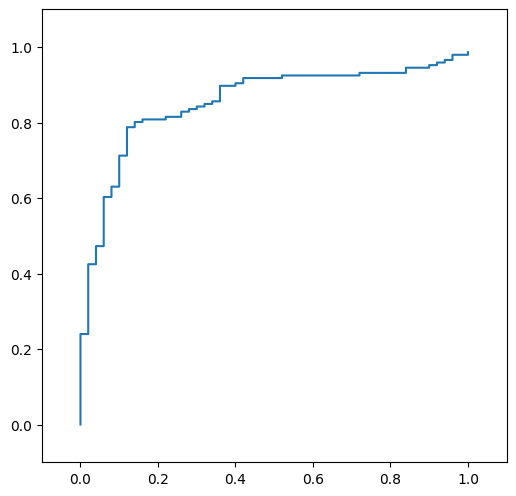

In [155]:
S_IOU = 0.05
H_IOU = 0.3
NMS_IOU = 0.01
    
Count_dict = deepcopy(seg_count_dict)
result_list = sorted([each for each in os.listdir(result_path) if each[0] == 'K'])

ensemble_case_list = None
ensemble_detections = []
ensemble_annotations = None

if True:
    for k_idx in range(0,5):
        tmp_result_npz = [each for each in result_list if each.startswith('K%s'%k_idx)][0]
        tmp_result_path = result_path + tmp_result_npz
        tmp_result_file = np.load(tmp_result_path, allow_pickle=True)

        case_list = tmp_result_file['case']
        all_detections = tmp_result_file['det']
        all_annotations = tmp_result_file['anno']

        if k_idx == 0:
            ensemble_case_list = case_list
            ensemble_annotations = all_annotations

        for i in range(len(case_list)):
            case_name = case_list[i]
            seg_anno_name = '_'.join(case_name.split('_')[:-1])

            detections = all_detections[i]
            detections[:,4] = detections[:,4] * K_pid_score[str(k_idx)][seg_anno_name]

            if k_idx == 0:
                ensemble_detections.append([detections])
            else:
                ensemble_detections[i] += [detections]

    false_positives = np.zeros((0,))
    true_positives = np.zeros((0,))
    scores = np.zeros((0,))
    num_annotations = 0.0

    case_list = ensemble_case_list
    all_detections = ensemble_detections
    all_annotations = ensemble_annotations

    false_positives = np.zeros((0,))
    true_positives = np.zeros((0,))
    scores = np.zeros((0,))
    num_annotations = 0.0

    pid_seg_tp_score = {}
    neg_seg_fp_score = {}
    neg_pid_list = []
    neg_score_list = []

    for i in range(len(case_list)):
        case_name = case_list[i]
        seg_anno_name = '_'.join(case_name.split('_')[:-1])

        if seg_anno_name not in pid_seg_tp_score:
            pid_seg_tp_score[seg_anno_name] = {}

        if seg_anno_name not in neg_seg_fp_score and seg_anno_name[0] == 'I':
            neg_seg_fp_score[seg_anno_name] = 0

        if case_name + '.npz' in SEG_anno_list:
            SEG_anno = np.load(SEG_anno_path + case_name + '.npz')['BBOX']
            
        annotations = ensemble_annotations[i]
        num_annotations += annotations.shape[0]
        detected_annotations = []
        
        detections = ensemble_detections[i]
        detections_concat = np.concatenate(detections, axis=0)
        
        if len(detections_concat) == 0 and annotations.shape[0] == 0 and seg_anno_name[0] == 'I':
            neg_pid_list.append(seg_anno_name)
            neg_score_list.append(0)
            continue
        
        boxes_list = [each[:,:4] / 448 for each in detections]
        scores_list = [each[:,-1] for each in detections]
        labels_list = [np.ones_like(each[:,-1]) for each in detections]
        weights = [1,1,1,1,1]
        iou_thr = 0.1
        skip_box_thr = 0.0001
        
        boxes, nms_scores, labels = non_maximum_weighted(boxes_list, 
                                            scores_list, 
                                            labels_list, 
                                            weights=weights, 
                                            iou_thr=iou_thr,
                                            skip_box_thr=skip_box_thr)
        
        boxes = boxes * 448
        nms_scores = nms_scores[:,np.newaxis]
        detections = np.concatenate([boxes, nms_scores], axis=1)

        if len(detections) == 0 and annotations.shape[0] == 0 and seg_anno_name[0] == 'I':
            neg_pid_list.append(seg_anno_name)
            neg_score_list.append(0)
            continue

        for d in detections:
            if d[4] < S_IOU:
                continue

            tmp_score = d[4]  * K_pid_score[str(k_idx)][seg_anno_name]

            if annotations.shape[0] == 0:
                false_positives = np.append(false_positives, 1)
                true_positives = np.append(true_positives, 0)

                if seg_anno_name[0] == 'I':
                    neg_pid_list.append(seg_anno_name)
                    neg_score_list.append(tmp_score)
                    neg_seg_fp_score[seg_anno_name] = max(neg_seg_fp_score[seg_anno_name], tmp_score)
                continue

            d_tensor = torch.tensor(d[:4][np.newaxis])
            a_tensor = torch.tensor(annotations)
            overlaps = box_iou(d_tensor, a_tensor).numpy()
            assigned_annotation = np.argmax(overlaps, axis=1)
            max_overlap = overlaps[0, assigned_annotation]

            if max_overlap >= H_IOU:
                x1,y1,x2,y2 = a_tensor[assigned_annotation].data.numpy().astype('uint16')[0]
                x_mid = (x1+x2)//2
                y_mid = (y1+y2)//2

                hit_anno = SEG_anno[y_mid, x_mid]
                if hit_anno == 0:
                    continue
                elif hit_anno in Count_dict[seg_anno_name]['Hit']:
                    continue
                else:
                    Count_dict[seg_anno_name]['Hit'].append(hit_anno)

                if seg_anno_name[0] != 'I':
                    hit_anno_name = str(hit_anno)
                    if hit_anno_name not in pid_seg_tp_score[seg_anno_name]:
                        pid_seg_tp_score[seg_anno_name][hit_anno_name] = tmp_score
                    else:
                        ori_score = pid_seg_tp_score[seg_anno_name][hit_anno_name]
                        pid_seg_tp_score[seg_anno_name][hit_anno_name] = max(ori_score, tmp_score)
            else:
                if seg_anno_name[0] == 'I':
                    neg_pid_list.append(seg_anno_name)
                    neg_score_list.append(tmp_score)
                    neg_seg_fp_score[seg_anno_name] = max(neg_seg_fp_score[seg_anno_name], tmp_score)

    seg_label_list = []
    hit_label_list = []
    for name in Count_dict:
        seg_label_list += Count_dict[name]['GT']
        hit_label_list += Count_dict[name]['Hit']

    seg_num = len(seg_label_list)
    hit_num = len(hit_label_list)

    pos_score_list = []
    for pid in pid_seg_tp_score:
        for hit_anno_name in pid_seg_tp_score[pid]:
            score = pid_seg_tp_score[pid][hit_anno_name]
            pos_score_list.append(score)

    unique_score_list = sorted(list(set(pos_score_list + neg_score_list)))
    unique_score_list.insert(0, -1)
    unique_score_list.append(1.1)

    unique_pid_list = np.unique(np.array(neg_pid_list).tolist())
    Neg_pid_num = len(np.unique(np.array(neg_pid_list).tolist()))

    sens_case_list = []
    spec_pid_list = []

    for th_score in unique_score_list:
        TP_case_num = np.sum(np.array(pos_score_list) > th_score)
        sens_case = TP_case_num / seg_num
        sens_case_list.append(sens_case)

        FP_pid_num = len(np.unique(np.array(neg_pid_list)[np.array(neg_score_list) > th_score]).tolist())
        spec_pid_list.append(FP_pid_num/Neg_pid_num)

    # for sens_idx, sens in enumerate(sens_case_list):
    #     print(sens, spec_pid_list[sens_idx])

    print(seg_num, hit_num, round(hit_num / seg_num,4))
    print('AFROC:', auc(spec_pid_list, sens_case_list).round(4))

    for i in sorted(list(set(seg_label_list))):
        mat = "{:2} {:2} {:2} {:}"
        hit_num = np.sum(np.array(hit_label_list)==i)
        seg_num = np.sum(np.array(seg_label_list)==i)
        print(mat.format(i, hit_num, seg_num, (hit_num / seg_num).round(4)))


    fig = plt.figure(figsize=(6,6),dpi=100)
    plt.plot(spec_pid_list, sens_case_list)
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.show()

In [147]:
for H_IOU in [0.1, 0.2, 0.3, 0.4, 0.5]:
    print('=========== Hit IoU %s ========='%H_IOU)
    S_IOU = 0.05
    NMS_IOU = 0.01

    result_list = sorted([each for each in os.listdir(result_path) if each[0] == 'K'])

    ensemble_case_list = None
    ensemble_detections = []
    ensemble_annotations = None

    for k_idx in range(0,5):
        tmp_result_npz = [each for each in result_list if each.startswith('K%s'%k_idx)][0]
        tmp_result_path = result_path + tmp_result_npz
        tmp_result_file = np.load(tmp_result_path, allow_pickle=True)

        case_list = tmp_result_file['case']
        all_detections = tmp_result_file['det']
        all_annotations = tmp_result_file['anno']

        if k_idx == 0:
            ensemble_case_list = case_list
            ensemble_annotations = all_annotations

        for i in range(len(case_list)):
            case_name = case_list[i]
            seg_anno_name = '_'.join(case_name.split('_')[:-1])

            detections = all_detections[i]
            detections[:,4] = detections[:,4] * K_pid_score[str(k_idx)][seg_anno_name]

            if k_idx == 0:
                ensemble_detections.append([detections])
            else:
                ensemble_detections[i] += [detections]
   
    false_positives = np.zeros((0,))
    true_positives = np.zeros((0,))
    scores = np.zeros((0,))
    num_annotations = 0.0
    
    case_list = ensemble_case_list
    all_detections = ensemble_detections
    all_annotations = ensemble_annotations

    for i in range(len(case_list)):
        case = case_list[i]
        pid = '_'.join(case.split('_')[:-1])

        annotations = ensemble_annotations[i]
        num_annotations += annotations.shape[0]
        detected_annotations = []

        detections = ensemble_detections[i]
        detections_concat = np.concatenate(detections, axis=0)
        
        if len(detections_concat) == 0:
            continue
        
        boxes_list = [each[:,:4] / 448 for each in detections]
        scores_list = [each[:,-1] for each in detections]
        labels_list = [np.ones_like(each[:,-1]) for each in detections]
        weights = [1,1,1,1,1]
        iou_thr = 0.1
        skip_box_thr = 0.0001
        
        boxes, nms_scores, labels = non_maximum_weighted(boxes_list, 
                                            scores_list, 
                                            labels_list, 
                                            weights=weights, 
                                            iou_thr=iou_thr,
                                            skip_box_thr=skip_box_thr)
        
        boxes = boxes * 448
        nms_scores = nms_scores[:,np.newaxis]
        detections = np.concatenate([boxes, nms_scores], axis=1)

        for d in detections:
            if d[4] < S_IOU:
                continue

            tmp_score = d[4]  * K_pid_score[str(k_idx)][pid]
            scores = np.append(scores, tmp_score)

            if annotations.shape[0] == 0:
                false_positives = np.append(false_positives, 1)
                true_positives = np.append(true_positives, 0)
                continue

            d_tensor = torch.tensor(d[:4][np.newaxis])
            a_tensor = torch.tensor(annotations)
            overlaps = box_iou(d_tensor, a_tensor).numpy()
            assigned_annotation = np.argmax(overlaps, axis=1)
            max_overlap = overlaps[0, assigned_annotation]

            if max_overlap >= H_IOU and assigned_annotation not in detected_annotations:
                false_positives = np.append(false_positives, 0)
                true_positives = np.append(true_positives, 1)
                detected_annotations.append(assigned_annotation)
            else:
                false_positives = np.append(false_positives, 1)
                true_positives = np.append(true_positives, 0)

    if len(false_positives) == 0 and len(true_positives) == 0:
        print('No detection')
    else:
        # sort by score
        indices = np.argsort(-scores)
        scores = scores[indices]
        false_positives = false_positives[indices]
        true_positives = true_positives[indices]

        anno = num_annotations
        case_num = len(case_list)

        # compute false positives and true positives
        false_positives = np.cumsum(false_positives)
        true_positives = np.cumsum(true_positives)

        # compute recall and precision
        recall = true_positives / num_annotations
        precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)

        # compute average precision
        average_precision = compute_ap(recall, precision)

        print('mAP: {:.4f}'.format(average_precision))

=========== Hit IoU 0.1 =========
mAP: 0.8489
=========== Hit IoU 0.2 =========
mAP: 0.8420
=========== Hit IoU 0.3 =========
mAP: 0.8306
=========== Hit IoU 0.4 =========
mAP: 0.7957
=========== Hit IoU 0.5 =========
mAP: 0.7150
